# Étape 4: géotraitement - évaluation de la zone industrielle

Dans cette étape nous allons déterminer **le nombre de personnes dans le périmètre autour de la zone industrielle**.

Le calcul du nombre de personnes est fait selon les indications dans l'Ordonnance sur la Protection contre les Accidents Majeurs (OPAM):

Nombre de personnes présentes pendant un jour de semaine:  
$N_{jsem} = 0.3 \cdot P + 0.8 \cdot E$  
où $P$ est la population résidente et $E$ le nombre d'emplois.

Nombre de personnes présentes pendant une nuit de semaine:  
$N_{nsem} = 0.9 \cdot P + 0.05 \cdot E$

Nombre de personnes présentes pendant un jour de weekend:  
$N_{jwe} = 0.6 \cdot P + 0.05 \cdot E$

Nombre de personnes présentes pendant une nuit de weekend:  
$N_{nwe} = P$

Les périmètres considérés sont: 500 m, 1 km, et 5 km.

Nous souhaitons obtenir **le nombre de personnes par périmètre et par commune**.

Nous allons faire l'intégralité de cette analyse **avec Geopandas**, à priori sur Google Colab.

Les étapes de travail sont en gros:

1. Création des périmètres de 500 m, 1 km et 5 km
2. Intersection des périmètres avec les communes afin de savoir quelle partie de quel périmètre se trouve dans quelle commune.
3. Déterminer le nombre d'habitants et d'emplois pour chaque périmètre-commune.
4. Calcul du nombre de personnes

Le résultat sera sauvegardé dans des fichiers CSV.

Les ressources conseillés pour l'étape 4 du projet sont en gros:

- Le tutoriel d'[introduction à GeoPandas sur Moodle](https://colab.research.google.com/github/gse-unil/2024_Geoinformatique_I/blob/main/Exercices-SIG/w10-2-selections-queries-joins/2-tuto-geopandas.ipynb). Il contient la plupart des éléments à mettre en oeuvre.

- La documentation officielle des modules Python utilisés, dont notamment [GeoPandas](https://geopandas.org) et [Pandas](http://pandas.pydata.org/).

- Votre moteur de recherche préféré et votre modèle IA préféré

- Échangez-vous avec vos collègues. Mais n'échangez pas de fichiers et ne copiez pas le code de quelqu'un d'autre. 

On n'écrit pas de code sans documentation, mais il faut comprendre ce qu'on fait. Si vous ne comprenez pas un élément, essayez de l'apprendre. 

## 1. Création des périmètres de 500 m, 1 km et 5 km

À partir du Geopackage de votre zone industrielle, créez une zone tampon pour chacun des périmètres.

Le module `pyogrio` permet de lister les couches à l'intérieur de votre Geopackage et ainsi lire la bonne couche. Vous trouvez un exemple dans le tutoriel GeoPandas.

Vous pouvez ensuite procéder au calcul de la zone tampon («buffer» en anglais).

Une chose importante à considérer est le fait que votre zone industrielle est composée de plusieurs polygones. GeoPandas crée une zone tampon par polygone. Il faudra donc fusionner les zones tampons obtenues. Ceci peut se faire avec l'opération [`union_all`](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#GeoSeries.union_all), ou si vous avez une vieille version de GeoPandas avec [`unary_union`](https://geopandas.org/en/v0.14.1/docs/reference/api/geopandas.GeoSeries.unary_union.html).

Regardez le type du résultat que vous obtenez de l'opération `union_all`. Il s'agit d'une géométrie [`Shapely`](https://shapely.readthedocs.io). Il s'agit du module Python utilisé par GeoPandas pour gérer les géométries.

Le calcul simple des zones tampons crée des zones qui se superposent. Pour pouvoir faire des sommes plus tard, il est préférable d'avoir des sortes d'anneaux, donc un anneau pour le périmètre entre 500 m et 1 km, et entre 1 km et 5 km. Un tel anneau ressemble à quelque chose comme ça:

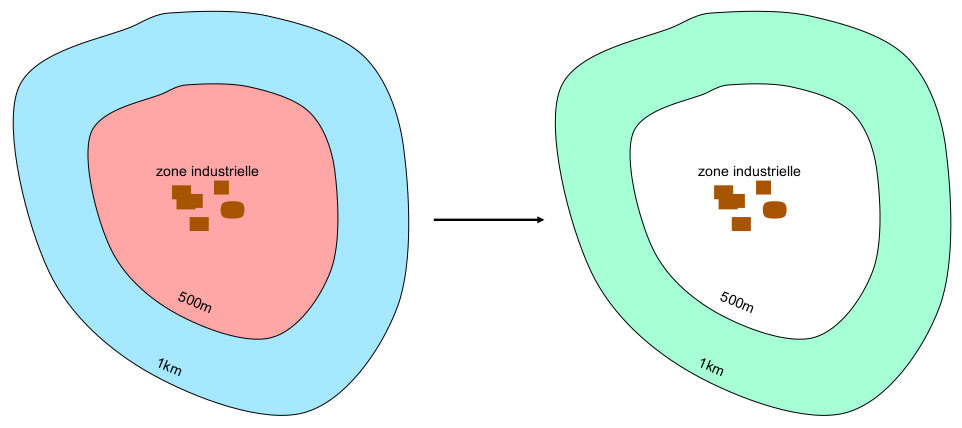

Pour obtenir une telle géométrie, il faut appliquer l'opérateur «difference». Il s'agit d'une fonction de Shapely, voir [ici](https://shapely.readthedocs.io/en/stable/manual.html#object.difference).

À la fin de cette étape, vous devez avoir trois zones tampon:

- celle de 500 mètres
- celle de 1 km après différence avec celle de 500 mètres
- la zone tampon de 5 km moins celle de 1 km

## 2. Intersection des périmètres avec les communes

Afin d'avoir un décompte des personnes non seulement par périmètre mais aussi par commune, nous devons intégrer l'information sur les communes dans chaque zone tampon.

Ceci peut se faire à l'aide d'une intersection avec la couche des communes. Prenez les communes pour toute la Suisse et non pas seulement pour le canton de Vaud. Les parties à l'étranger ne sont pas considérées et seront coupées à cette étape (nous n'avons pas les données statistiques pour l'étranger).

L'intersection peut se faire avec la fonction `overlay` de GeoPandas. Cette fonction demande deux GeoDataFrames. Après lecture du fichier Geopackage, nous avons bel et bien un GeoDataFrame pour les communes. Mais pour les zones tampon, nous avons des géométries brutes. Nous devons d'abord les transformer en GeoDataFrame avec quelque chose comme:

In [ ]:
gpd.GeoDataFrame(geometry=[zone_tampon], crs='EPSG:2056')

Par ailleurs, au lieu d'écrire le même code 3 fois (une fois pour chaque zone), nous pouvons l'intégrer dans une boucle. Nous pourrions par exemple d'abord créer un dictionnaire avec les 3 géométries des zones tampons (avec le périmètre comme clé et la géométrie comme valeur):

In [ ]:
zi_buf = { '500m': zi_500m, '1km': zi_1km_diff, '5km': zi_5km_diff }

Et ensuite nous pouvons faire une boucle à travers ce dictionnaire. À l'aide d'une *«compréhension de dictionnaire»* (*«dictionary comprehension»* en anglais), ceci peut se faire en une seule ligne de code (c'est bien une seule ligne de code, même si elle est écrite sur plusieurs lignes pour faire joli):

In [ ]:
zi_buf_gdf = {
    k: gpd.GeoDataFrame(geometry=[poly], crs='EPSG:2056')
    for k, poly in zi_buf.items()
}

À vous de voir si voulez adopter ou non ce style un peu plus succinct d'écrire votre code.

Une fois que vous avez fait l'intersection, inspectez le résultat. Regardez p.ex. d'abord la zone tampon seulement:

In [ ]:
zi_buf_gdf['500m']

Et ensuite le résultat après intersection:

In [ ]:
zi_buf_cmnes['500m']

Ceci vous doit indiquer si l'opération semble avoir marché.

Afficher également au moins une des zones avec `plot`, p.ex.

In [ ]:
zi_buf_cmnes['500m'].plot()

Vous avez maintenant un GeoDataFrame pour chaque zone tampon. Chaque zone tampon a été décomposée en plusieurs polygones, un polygone par commune.

Une fois que vous avez vérifié le résultat de vos calculs et que tout semble ok, vous pouvez passer au point suivant.

## 3. Déterminer le nombre d'habitants et d'emplois

Une fois que les zones tampon sont prêtes, il faut passer au calcul du nombre d'habitants et d'emplois. Ces données sont disponibles sous forme de points, un point par hectare. En gros, on va regarder quels points tombent à l'intérieur de quel polygone des zones tampon, et ensuite faire la somme du champ de population ou d'emplois de tous ces points à l'intérieur.

Pour cela, il faut faire une jointure spatiale entre la couche des points (avec le nombre d'habitants resp. d'emplois) et les polygones des zones tampon. Ainsi, les informations des polygones sont disponibles pour chaque point. Ensuite, il faut faire une opération «group by» avec le calcul de la somme sur colonne des habitants ou des emplois.

Vous disposez d'une fonction qui fait cette tâche d'une jointure spatiale suivi du calcul de la somme après «group by»:

In [ ]:
def sjoin_summarize(poly_lyr, pts_lyr, pts_colname, poly_newcolname):
    """
    poly_lyr:         la couche des polygones
    pts_lyr:          la couche des points
    pts_colname:      la colonne sur laquelle il faut faire la somme
    poly_newcolname:  le nom de la colonne à créer dans la couche
                      des polygones
    """
    # Faire d'abord une jointure spatiale pour associer chaque point à un polygone
    sjoin = pts_lyr.sjoin(poly_lyr, how='inner', predicate='within')
    
    # Faire une opération «group by» selon l'index du polygone, et calculer la somme
    somme_par_poly = sjoin.groupby(sjoin.index_right)[pts_colname].sum()
    
    # Enregistrer le résultat dans la couche des polygones
    poly_lyr[poly_newcolname] = poly_lyr.index.map(somme_par_poly)

Étudiez cette fonction pour bien comprendre ce qu'elle fait. Regardez chaque ligne de code. Ensuite, faites le calcul pour chacune des zones tampon et le nombre d'habitants et emplois. Il faut évidemment d'abord charger les deux couches que vous aviez créées dans une étape précédente avec `ogr2ogr`.

À la fin, vous devriez avoir 3 GeoDataFrames, un pour chaque zone tampon, avec deux nouvelles colonnes, une pour les habitants et une pour les emplois.

Insérez dans chaque GeoDataFrame une nouvelle colonne `peri` qui contient la valeur `500m`, `1km` ou `5km`. Cela permettra d'identifier à quel périmètre s'appique une ligne du tableau.

Nous allons calculer le nombre de personnes à la fois par commune et par zone tampon. Pour cela, nous devrions avoir un tableau qui ressemble à ça:

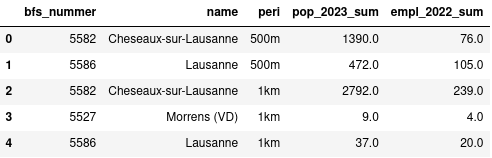

Pour le moment, cette information est répartie à travers les 3 GeoDataFrames. Nous devons donc:

- extraire les colonnes nécessaires de chaque GeoDataFrame
- joindre toutes les données dans un seul tableau

Le tableau que nous utilisons est un DataFrame Pandas.

Pour extraire les colonnes, il suffit de passer une liste des colonnes souhaitées:

In [ ]:
data_500m = zi_buf_cmnes_500m[['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]

Et pour joindre toutes les données, il faut les «concaténer». Pandas possède une fonction pour le faire. Ce sera quelque chose comme:

In [ ]:
pd.concat([data_500m, data_1km, data_5km], ignore_index=True)

Consultez la [documentation de Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) pour comprendre ce que ce code fait.

Affichez le résultat qui doit être un tableau similaire à celui plus haut. Vous allez constater que certaines des valeurs sont des `NaN`. Remplacez ces valeurs par 0, sinon on aura des difficultés à faire la somme.

Avec ça, le DataFrame Pandas sera prêt pour le point suivant.

## Calcul du nombre de personnes

Nous pouvons maintenant appliquer les 4 formules pour calculer le nombre de personnes à chaque moment dans la semaine, selon les formules définies dans l'OPAM.

Créez une nouvelle colonne pour chaque formule. Nommez les colonnes de la façon suivante:

- `Njsem`: Nombre de personnes présentes pendant un jour de semaine
- `Nnsem`: Nombre de personnes présentes pendant une nuit de semaine
- `Njwe`: Nombre de personnes présentes pendant un jour de weekend
- `Nnwe`: Nombre de personnes présentes pendant une nuit de weekend

Vous trouvez les formules au début de ce document.

Sauvegardez ensuite le DataFrame Pandas résultat dans un fichier CSV. Nommez le fichier `personnes_par_peri_et_cmne.csv` et enregistrez-le dans le dossier `resultats` de votre projet.

Sur la base de ce DataFrame, il est facile d'extraire les informations par zone tampon et par commune.

Faites d'abord l'extraction par périmètre. Pour cela, il faut d'abord extraire les colonnes suivantes:

`peri` (la colonne qui contient la zone tampon, p.ex. `500m`, `1km` et `5km`), `Njsem`, `Nnsem`, `Njwe` et `Nnwe`.

Ensuite nous pouvons faire une agrégation de type «group by» avec le calcul de la somme. C'est quelque chose du genre:

In [ ]:
data_peri.groupby('peri', as_index=False).sum()

Vous devriez ensuite avoir un nouveau DataFrame Pandas qui ressemble à quelque chose du genre (sans les colonnes de la population et des habitants):

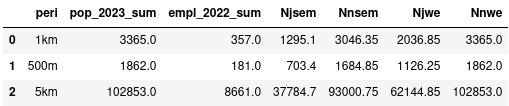

Enregistrez votre tableau dans le dossier des résultats de votre projet, sous forme d'un fichier CSV. Nommez le fichier `personnes_par_peri.csv`.

Faites ensuite la même opération pour les communes. Dans l'instruction `groupby`, utilisez à la fois la colonne `bfs_nummer` et `name`, du genre:

In [ ]:
___.groupby(['bfs_nummer', 'name'], ___).sum()

Sauvegardez le résultat de cette opération dans un fichier CSV avec nom `personnes_par_cmne.csv`. Enregistrez-le aussi dans le dossier des résultats de votre projet SIG.

À ce stade, vous avez calculé le nombre de personnes par périmètre et par commune. Félicitations!